In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt

%matplotlib notebook

# Load the dataset... This can take a while
if("mnist" not in globals()):  # Don't load the dataset twice...
    mnist = fetch_openml('mnist_784', version=1)
    # Convert DataFrame to 24x24 numpy arrays...
    imgs = mnist.data.to_numpy().reshape(70000, 28, 28).astype(np.float32)
    # Labels for the mnist data, 0-9 being the number...
    labels = np.asarray(mnist.target).astype(int)
    
    imgs_train, imgs_test, labels_train, labels_test = train_test_split(
        imgs, labels, test_size=0.2, random_state=1
    )

<IPython.core.display.Javascript object>


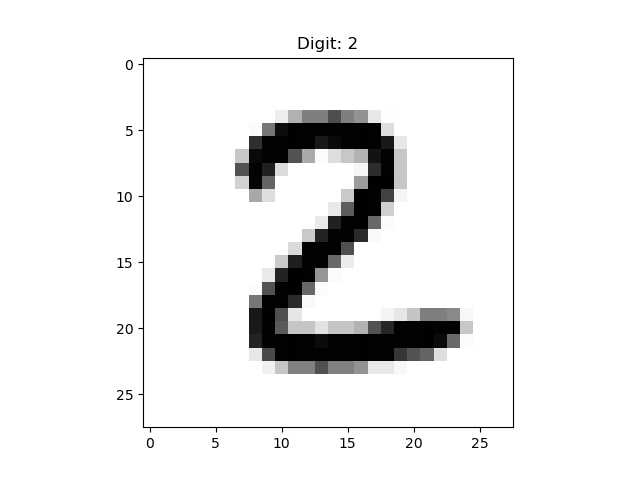

In [2]:
# Let's plot a digit at random...
idx = np.random.randint(0, imgs.shape[0])
single_digit = imgs[idx]
single_label = labels[idx]

plt.title(f"Digit: {single_label}")
plt.imshow(single_digit, cmap="Greys")
plt.show()

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [4]:
# Set the batch size: (Will be set to None in the final version)
batch_size = 100

# Set up data loaders, these will be used to train and test models...
to_device = lambda a: torch.from_numpy(a).to(device)

train_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_train), to_device(labels_train)),
    batch_size = batch_size,
    shuffle = True
)

test_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_test), to_device(labels_test)),
    batch_size = batch_size,
    shuffle = True
)

## Simple Model: Fully Connected NN

In [5]:
from typing import List

class SimpleNet(nn.Module):
    def __init__(
        self, 
        img_w: int, 
        img_h: int, 
        hidden_layer_sizes: List[int], 
        class_size: int
    ):
        super().__init__()
        
        self._in_layer = nn.Linear(img_w * img_h, hidden_layer_sizes[0])
        
        layers = []
        for hls1, hls2 in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([nn.Linear(hls1, hls2), nn.ReLU()])
        
        self._hidden_layers = nn.Sequential(*layers)
        
        self._out_layer = nn.Linear(hidden_layer_sizes[-1], class_size)
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.reshape(-1, img_w * img_h)
        
        x = self._in_layer(x)
        x = self._hidden_layers(x)
        return self._softmax(self._out_layer(x))

In [6]:
# Set these! (We'll replace these with None in the final version...)
img_w = 28
img_h = 28
hidden_layer_sizes = [2000, 1000, 500, 100, 20]  # List of None
class_size = 10

simple_net = SimpleNet(img_w, img_h, hidden_layer_sizes, class_size)
simple_net.to(device)

SimpleNet(
  (_in_layer): Linear(in_features=784, out_features=2000, bias=True)
  (_hidden_layers): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=20, bias=True)
    (7): ReLU()
  )
  (_out_layer): Linear(in_features=20, out_features=10, bias=True)
  (_softmax): Softmax(dim=1)
)

In [14]:
# Functions for training a model...
def train_model(model, train_data, test_data, optimizer, error_func, n_epochs, print_every = 300):
    for epoch_i in range(1, n_epochs + 1):
        for i, (img, label) in enumerate(train_data, 1):
            model.zero_grad()
            predicted = model.forward(img)
            loss = error_func(predicted, label)
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set at the end of each epoch to get accuracy...
        acc1 = get_accuracy(model, train_data)
        print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
        acc2 = get_accuracy(model, test_data)
        print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%")
    
    return model
        
        
def get_accuracy(model, data, im_mod = None):
        run = 0
        correct = 0
        
        for img, label in data:
            img = im_mod(img) if(im_mod is not None) else img   # Allows us to modify the images...
            run += len(img)
            result = model.forward(img).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

In [8]:
# Set these! (We'll replace these with None in final version)
n_epochs = 30
lr = 1e-3

# Set up everything...
optimizer = optim.SGD(simple_net.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [9]:
# Train the model...
train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs)

Epoch: 1/30, Iter: 300/560, Loss: 2.0194
Epoch: 1/30, Iter: 560/560, Loss: 1.9068
Epoch 1 Train Accuracy: 63.04%
Epoch 1 Test Accuracy: 62.87%
Epoch: 2/30, Iter: 300/560, Loss: 1.7884
Epoch: 2/30, Iter: 560/560, Loss: 1.8268
Epoch 2 Train Accuracy: 74.44%
Epoch 2 Test Accuracy: 73.76%
Epoch: 3/30, Iter: 300/560, Loss: 1.7768
Epoch: 3/30, Iter: 560/560, Loss: 1.7342
Epoch 3 Train Accuracy: 75.37%
Epoch 3 Test Accuracy: 74.55%
Epoch: 4/30, Iter: 300/560, Loss: 1.7130
Epoch: 4/30, Iter: 560/560, Loss: 1.7032
Epoch 4 Train Accuracy: 75.97%
Epoch 4 Test Accuracy: 75.27%
Epoch: 5/30, Iter: 300/560, Loss: 1.7495
Epoch: 5/30, Iter: 560/560, Loss: 1.6949
Epoch 5 Train Accuracy: 76.44%
Epoch 5 Test Accuracy: 75.69%
Epoch: 6/30, Iter: 300/560, Loss: 1.7333
Epoch: 6/30, Iter: 560/560, Loss: 1.6134
Epoch 6 Train Accuracy: 76.75%
Epoch 6 Test Accuracy: 75.99%
Epoch: 7/30, Iter: 300/560, Loss: 1.7446
Epoch: 7/30, Iter: 560/560, Loss: 1.7256
Epoch 7 Train Accuracy: 76.99%
Epoch 7 Test Accuracy: 76.26%

SimpleNet(
  (_in_layer): Linear(in_features=784, out_features=2000, bias=True)
  (_hidden_layers): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=20, bias=True)
    (7): ReLU()
  )
  (_out_layer): Linear(in_features=20, out_features=10, bias=True)
  (_softmax): Softmax(dim=1)
)

### Is it Robust to Translations

Not bad! Let's try seeing the accuracy when "shift" the results around just a little bit...

<IPython.core.display.Javascript object>


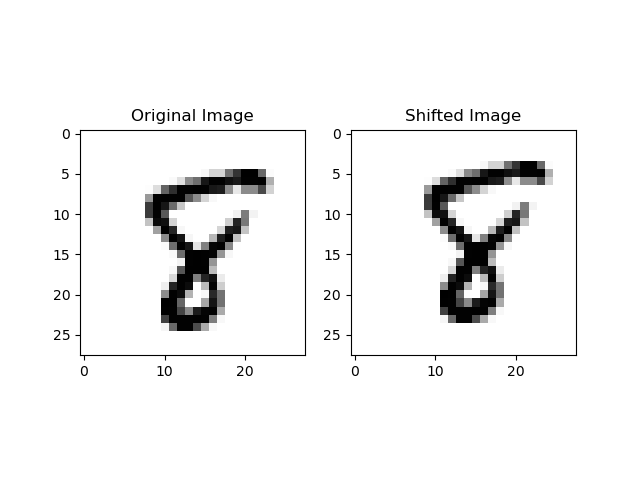

In [36]:
def img_shift(img):
    # Shifts and image between 0 and 5 pixels left and right in both dimensions
    x_trans, y_trans = np.random.randint(-5, 6, (2,))
    img = torch.roll(img, y_trans, 0)
    img = torch.roll(img, x_trans, 1)
    return img

# Show what img_shift does...
random_idx = np.random.randint(0, len(imgs))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original Image")
ax2.set_title("Shifted Image")
ax1.imshow(imgs[random_idx], cmap="Greys")
ax2.imshow(img_shift(torch.from_numpy(imgs[random_idx])), cmap="Greys")

fig.show()

In [37]:
def img_shift(img):
    x_trans, y_trans = np.random.randint(-5, 6, (2,))
    img = torch.roll(img, y_trans, 0)
    img = torch.roll(img, x_trans, 1)
    return img

print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader)}")
print(f"Translation Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift)}")

Normal Test Accuracy: 0.8652142857142857
Translation Test Accuracy: 0.14664285714285713


Yikes! Shifting around the numbers destroys the accuracy of our simple fully connected network. 

# Using a CNN

TODO...

# Using a RetNet